# 06 - BackTesting

In [63]:
# imports
import pandas as pd
import numpy as np
import joblib
import os
import tensorflow as tf
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss


#notebook settings
pd.set_option('display.max_columns', None)

# Disable GPU usage (if not using GPU)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Suppress all TensorFlow logs and CUDA warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Only show errors
warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow")

# Set TensorFlow log level to ERROR (to suppress info and warnings)
tf.get_logger().setLevel('ERROR')

In [68]:
# load the data
data = pd.read_csv(os.path.join('..','data','processed','prepared_football_data.csv'))

data_for_back_testing = data[['implied_home_win_prob','implied_draw_prob','implied_away_win_prob']]

# load the model
best_model= tf.keras.models.load_model(os.path.join('..','models','model_best.keras'))

# load feature_info, ct and label_encoder
feature_info = np.load(os.path.join('..','models','feature_info.npy'), allow_pickle=True).item()
ct = joblib.load(os.path.join('..', 'models', 'column_transformer.pkl'))
label_encoder = joblib.load(os.path.join('..', 'models', 'label_encoder.pkl'))

In [69]:
# train test split
X = data.drop(columns=['full_time_result'])
y = data['full_time_result']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    shuffle=False)


print(X.shape, y.shape, X_train.shape)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7429, 97) (7429,) (5943, 97)
(5943, 97) (1486, 97) (5943,) (1486,)


In [70]:
# get predictions
y_pred_prob = best_model.predict(ct.transform(X_test))

y_pred_prob

 1/47 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([[0.8706909 , 0.12266286, 0.00664625],
       [0.67171985, 0.27694845, 0.05133166],
       [0.40939355, 0.32573587, 0.26487073],
       ...,
       [0.00679725, 0.13467838, 0.8585244 ],
       [0.68488383, 0.27315176, 0.04196437],
       [0.00161715, 0.0655435 , 0.93283933]], dtype=float32)

In [71]:
# get labels from predictions
y_pred = label_encoder.inverse_transform(np.argmax(y_pred_prob, axis=1))

y_pred

array(['A', 'A', 'A', ..., 'H', 'A', 'H'], dtype=object)

In [72]:
team_names = X_test.loc[:, ['home_team', 'away_team']].copy()

team_names['true_results'] = y_test

team_names['predicted_results'] = y_pred

# Unpack y_pred_proba (probabilities for [Away, Draw, Home])
team_names[['away_prob', 'draw_prob', 'home_prob']] = pd.DataFrame(y_pred_prob, index=team_names.index)

team_names[['implied_home_win_prob', 'implied_draw_prob', 'implied_away_win_prob']] = data_for_back_testing.loc[team_names.index, ['implied_home_win_prob', 'implied_draw_prob', 'implied_away_win_prob']]

team_names = team_names[['home_team', 'away_team', 'true_results','predicted_results', 
                         'home_prob', 'draw_prob', 'away_prob', 
                         'implied_home_win_prob', 'implied_draw_prob', 
                         'implied_away_win_prob']]


print(team_names.columns)

team_names.head()

Index(['home_team', 'away_team', 'true_results', 'predicted_results',
       'home_prob', 'draw_prob', 'away_prob', 'implied_home_win_prob',
       'implied_draw_prob', 'implied_away_win_prob'],
      dtype='object')


,home_team,away_team,true_results,predicted_results,home_prob,draw_prob,away_prob,implied_home_win_prob,implied_draw_prob,implied_away_win_prob
5943,aston villa,leicester,A,A,0.006646,0.122663,0.870691,0.331583,0.271898,0.396518
5944,arsenal,man city,A,A,0.051332,0.276948,0.671720,0.146317,0.219644,0.634039
5945,man united,newcastle,H,A,0.264871,0.325736,0.409394,0.734901,0.171032,0.094067
5946,brighton,crystal palace,A,A,0.022431,0.242849,0.734720,0.557164,0.270622,0.172214
5947,leeds,southampton,H,D,0.183652,0.427492,0.388856,0.422179,0.271401,0.306420


In [73]:
# Define a function to calculate the Brier score using sklearn
def calculate_brier_score(predictions, true_outcome):
    return brier_score_loss(true_outcome, predictions)

def encode_result(result):
    # 'H' = [1, 0, 0], 'D' = [0, 1, 0], 'A' = [0, 0, 1]
    if result == 'H':
        return [1, 0, 0]
    elif result == 'D':
        return [0, 1, 0]
    elif result == 'A':
        return [0, 0, 1]

team_names['true_predictions_brier'] = team_names['true_results'].apply(encode_result)

# Brier score for each row using the predicted probabilities
team_names['brier_score_market'] = team_names.apply(
    lambda row: calculate_brier_score(np.array([row['home_prob'], row['draw_prob'], row['away_prob']]), row['true_predictions_brier']),
    axis=1
)

# Brier score for the model
team_names['brier_score_model'] = team_names.apply(
    lambda row: calculate_brier_score(np.array([row['implied_home_win_prob'], row['implied_draw_prob'], row['implied_away_win_prob']]), row['true_predictions_brier']),
    axis=1
)

average_brier_score_market = team_names['brier_score_market'].mean()
average_brier_score_model = team_names['brier_score_model'].mean()

# Encode predicted_results to H, D, A
def decode_result(result):
    if result == 2:
        return 'H'
    elif result == 1:
        return 'D'
    elif result == 0:
        return 'A'
    
team_names['predicted_results'] = team_names['predicted_results'].apply(decode_result)

display(team_names[['home_team', 'away_team', 'true_results', 'predicted_results', 'brier_score_model', 'brier_score_market']])
print(f"Average Brier Score Market: {average_brier_score_market}")
print(f"Average Brier Score Model: {average_brier_score_model}")

,home_team,away_team,true_results,predicted_results,brier_score_model,brier_score_market
5943,aston villa,leicester,A,None,0.182689,0.010604
5944,arsenal,man city,A,None,0.067860,0.062368
5945,man united,newcastle,H,None,0.036126,0.271374
5946,brighton,crystal palace,A,None,0.356299,0.043284
5947,leeds,southampton,H,None,0.167143,0.333461
...,...,...,...,...,...,...
7424,leicester,crystal palace,A,None,0.127593,0.203245
7425,newcastle,wolves,H,None,0.043837,0.087068
7426,arsenal,tottenham,H,None,0.050964,0.012733
7427,ipswich,brighton,A,None,0.125773,0.058557


Average Brier Score Market: 0.16121086144902302
Average Brier Score Model: 0.18712530658492105


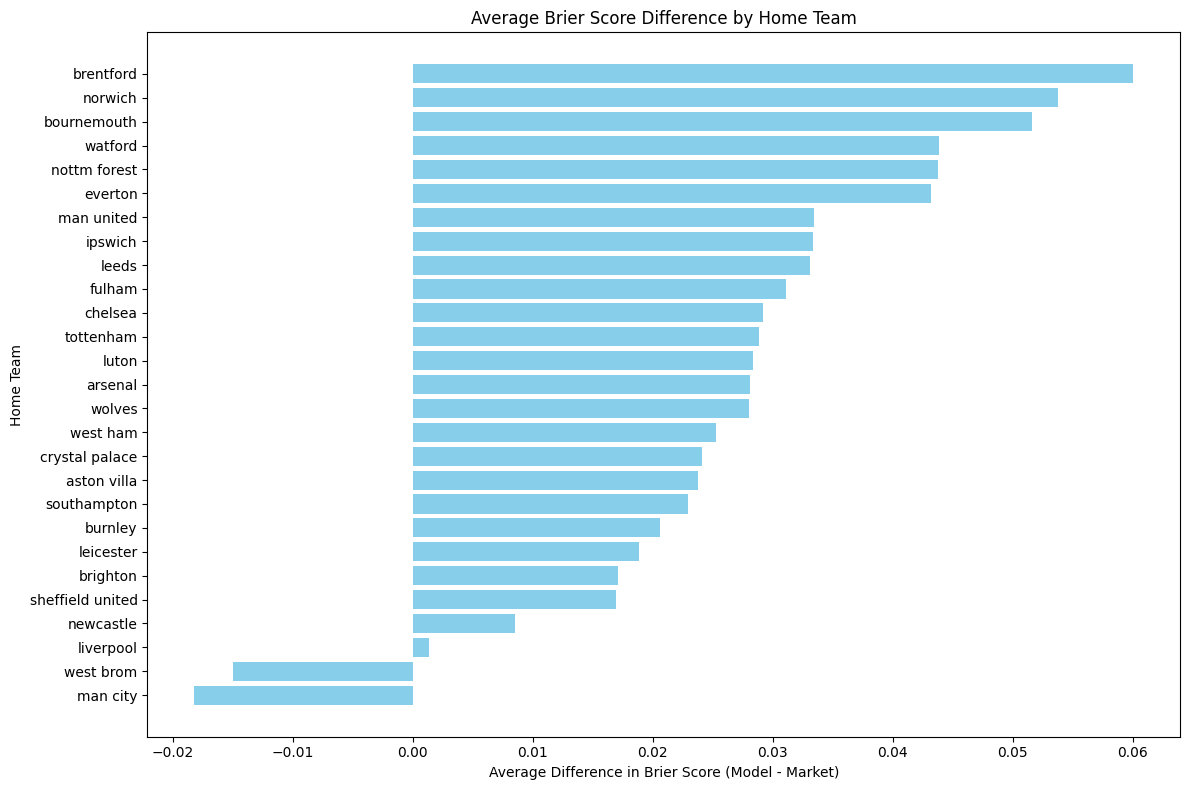

In [58]:
team_diff = team_names.groupby('home_team')[['brier_score_model', 'brier_score_market']].mean()
team_diff['brier_score_difference'] = team_diff['brier_score_model'] - team_diff['brier_score_market']
team_diff = team_diff.sort_values('brier_score_difference')

# Plot
plt.figure(figsize=(12, 8))
plt.barh(team_diff.index, team_diff['brier_score_difference'], color='skyblue')
plt.xlabel('Average Difference in Brier Score (Model - Market)')
plt.ylabel('Home Team')
plt.title('Average Brier Score Difference by Home Team')
plt.tight_layout()
plt.show()

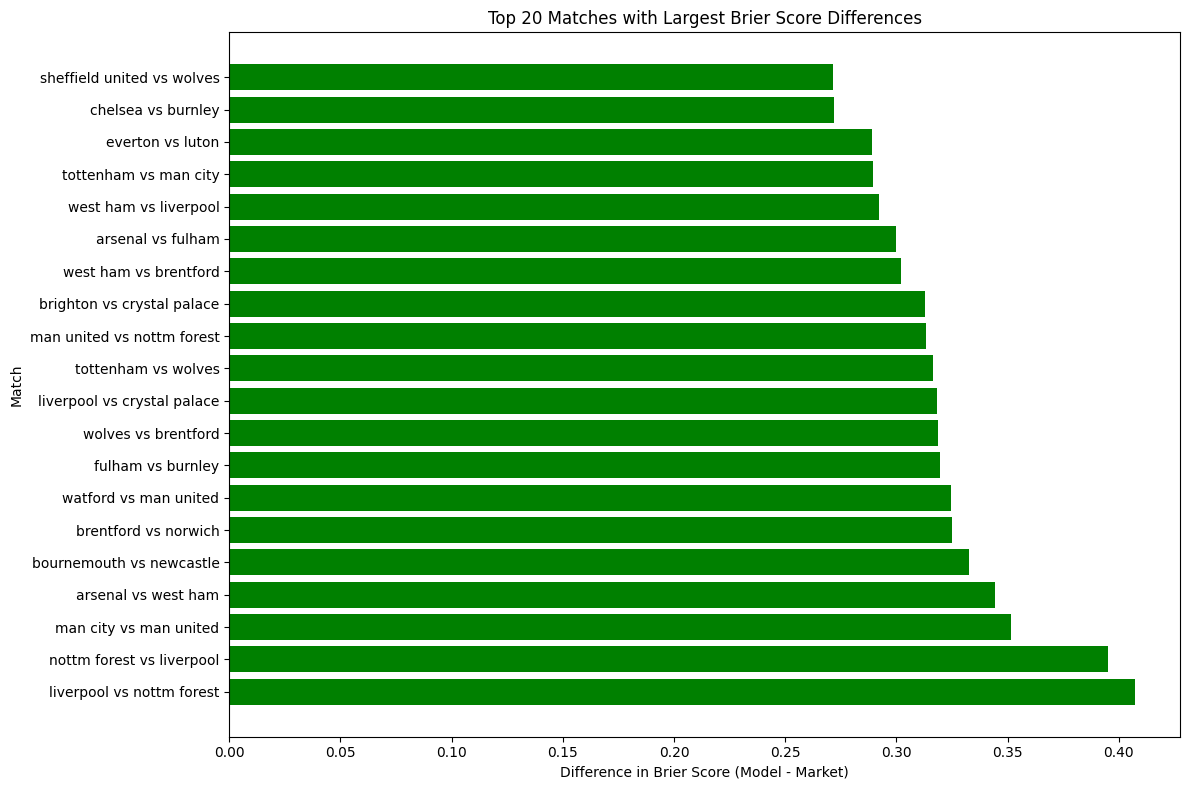

In [59]:

team_names['brier_score_difference'] = team_names['brier_score_model'] - team_names['brier_score_market']


top_matches = team_names.nlargest(20, 'brier_score_difference')


plt.figure(figsize=(12, 8))
plt.barh(top_matches['home_team'] + ' vs ' + top_matches['away_team'], top_matches['brier_score_difference'], color='green')
plt.xlabel('Difference in Brier Score (Model - Market)')
plt.ylabel('Match')
plt.title('Top 20 Matches with Largest Brier Score Differences')
plt.tight_layout()
plt.show()

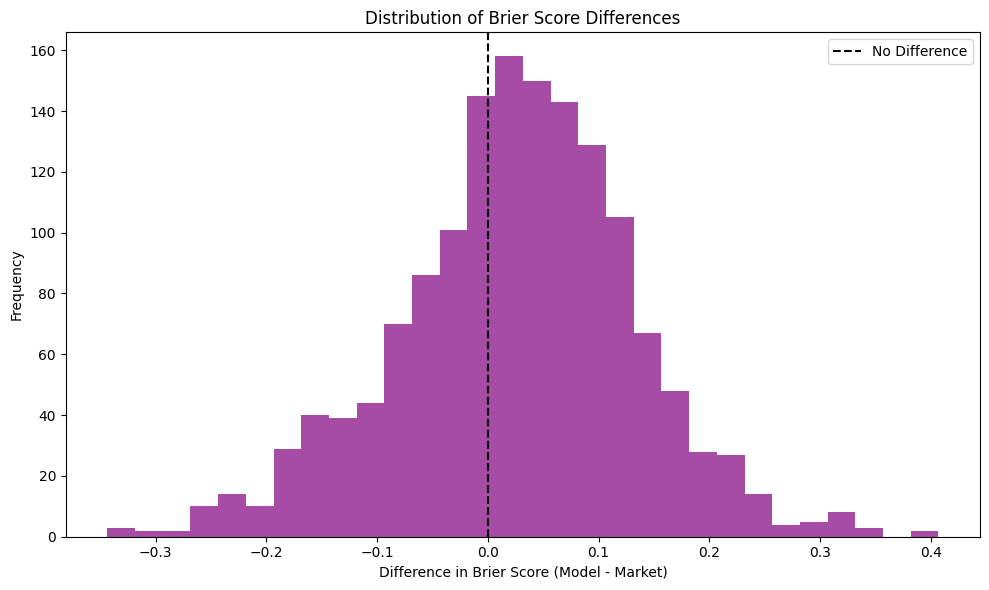

In [60]:
plt.figure(figsize=(10, 6))
plt.hist(team_names['brier_score_difference'], bins=30, color='purple', alpha=0.7)
plt.axvline(0, color='black', linestyle='--', label='No Difference')
plt.xlabel('Difference in Brier Score (Model - Market)')
plt.ylabel('Frequency')
plt.title('Distribution of Brier Score Differences')
plt.legend()
plt.tight_layout()
plt.show()

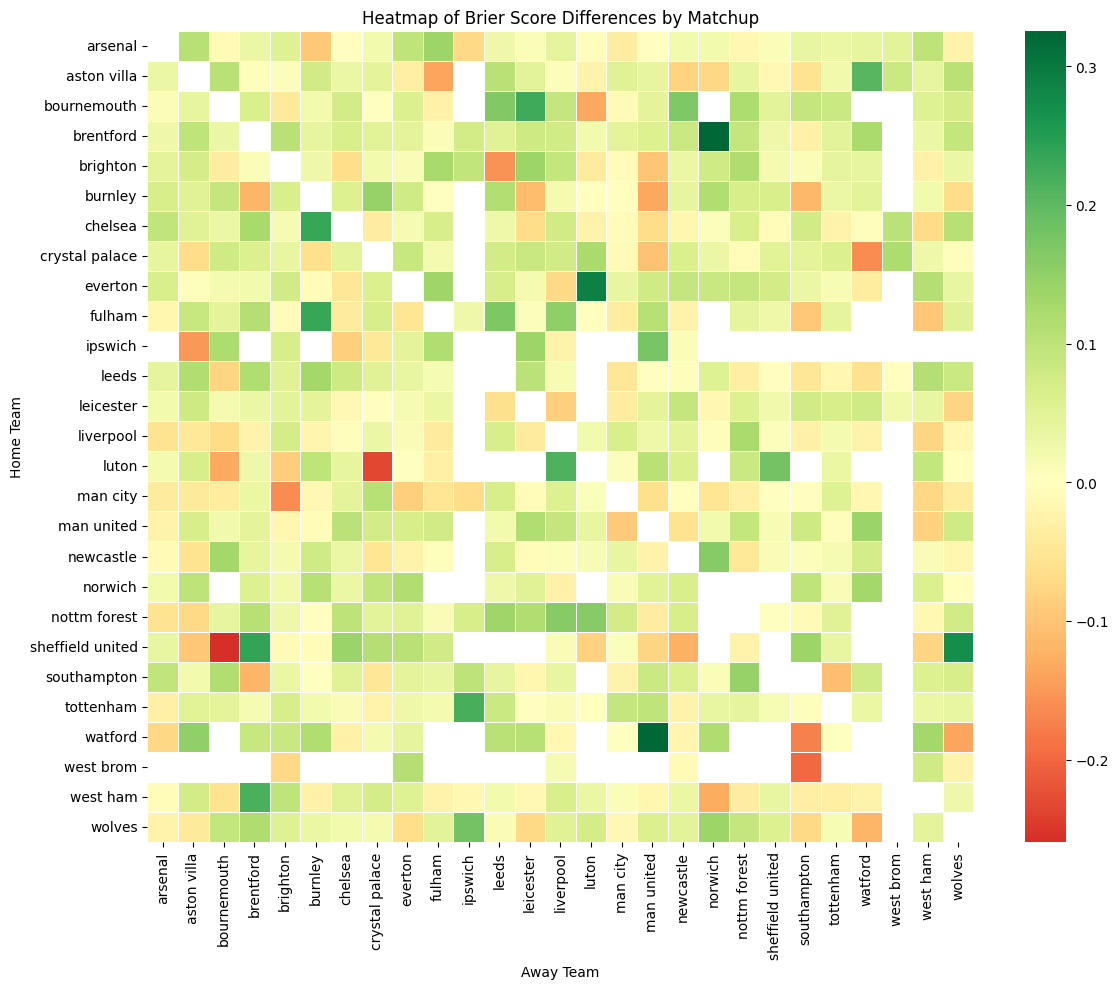

In [62]:
heatmap_data = team_names.pivot_table(index='home_team', columns='away_team', values='brier_score_difference', aggfunc='mean')


plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, annot=False, cmap='RdYlGn', center=0, linewidths=.5)
plt.title('Heatmap of Brier Score Differences by Matchup')
plt.xlabel('Away Team')
plt.ylabel('Home Team')
plt.tight_layout()
plt.show()